# Miscellaneous analyses in development

1. Variance in different features.
2. Consistency in burrito features.
3. Inter-reviewer reliability


Notes
* Considered repeated-measures anova, but best is dev statsmodels version. And only says whether there is significant variation over all categories, not which categories are most important. So I think I should use resampling.
* The method for determining pairs for inter-reviewer reliability could be improved to maximize the number of pairs

In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import numpy as np
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import math
from collections import defaultdict

In [2]:
import sys
import os.path
sys.path.append(os.path.abspath(os.path.dirname(os.getcwd())))

import util

### Load data

In [3]:
df, df_shops, df_ingredients = util.load_burritos()
df.tail()

,Location,Burrito,Date,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,...,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,overall,Rec,Reviewer,Notes
328,caliente mexican food,california,7/6/2017,6.47,4.0,NaN,NaN,23.0,22.0,0.89,...,2.0,3.0,3.0,1.0,2.0,3.0,2.0,NaN,erik k,NaN
329,taco villa,carne asada,7/12/2017,6.99,3.0,NaN,NaN,NaN,NaN,NaN,...,3.0,2.5,4.0,2.0,2.0,4.0,2.0,NaN,richard,NaN
330,taco villa,california,7/19/2017,6.99,4.0,NaN,NaN,20.5,21.5,0.75,...,3.5,3.5,3.5,3.5,3.5,5.0,3.7,NaN,scott,NaN
331,los tacos 2,local,7/22/2017,8.50,3.8,NaN,NaN,23.0,22.0,0.89,...,4.0,3.0,2.5,3.5,3.5,3.0,4.0,NaN,scott,NaN
332,los tacos 2,local,7/22/2017,8.50,4.0,NaN,NaN,22.0,21.0,0.77,...,4.0,3.5,3.5,4.0,5.0,3.5,4.0,NaN,emily,NaN


# 1. Variance within each burrito feature
Notice that the ingredient-based features are less variable than the preparation-based features

In [4]:
# Define features of interest
foi = ['Tortilla', 'Temp', 'Meat', 'Fillings', 'Meat:filling', 'Uniformity',
       'Salsa', 'Synergy', 'Wrap', 'overall']
df_feat = df[foi]

var_by_feat = df_feat.var()

# Print average difference in order
diff_sort_idx = np.argsort(var_by_feat.values)
print('Var    Feature')
for feat in var_by_feat.keys()[diff_sort_idx]:
    print('{:.2f} '.format(var_by_feat[feat]), feat)

Var    Feature
0.52  overall
0.60  Fillings
0.60  Tortilla
0.65  Meat
0.76  Synergy
0.82  Salsa
0.94  Meat:filling
0.95  Temp
1.12  Wrap
1.14  Uniformity


# 2. How consistent are burrito features?
### 2a. For each pair of burritos, compute the difference in each metric across trials

In [5]:
# Remove rows from dataframe that don't have values in necessary features
cols_keep = np.append(foi, ['Location', 'Burrito', 'Reviewer'])
df2 = df[cols_keep].dropna(axis=0).reset_index(drop=True)

# Determine groups of ratings of the same burrito at the same restaurant by the same person
brr_groups_all = df2.groupby(['Location', 'Burrito', 'Reviewer']).groups
brr_groups = {}
for k in list(brr_groups_all.keys()):
    if len(brr_groups_all[k])>1:
        brr_groups[k] = brr_groups_all[k]
        
# Limit the dataframe to the measures we want to analyze
df_feat = df2[foi]

# Compute difference in features for first 2 observations for each group
df_feat_diffs = pd.DataFrame()
for k in brr_groups.keys():
    feature_diffs = np.abs(df_feat.loc[brr_groups[k][1]] - df_feat.loc[brr_groups[k][0]])
    df_feat_diffs = df_feat_diffs.append(feature_diffs, ignore_index=True)
    
# Compute average difference in each category
meandiff_by_feat = df_feat_diffs.mean()

# Print average difference in order
diff_sort_idx = np.argsort(meandiff_by_feat.values)
print('Diff   Feature\n----   -------')
for feat in meandiff_by_feat.keys()[diff_sort_idx]:
    print('{:.2f}  '.format(meandiff_by_feat[feat]), feat)

Diff   Feature
----   -------
0.34   Meat
0.44   overall
0.46   Tortilla
0.50   Synergy
0.62   Fillings
0.67   Meat:filling
0.69   Wrap
0.83   Salsa
0.94   Temp
1.22   Uniformity


### 2b. Compute null distribution of differences between 2 random burritos

In [9]:
np.random.seed(0)
N_sim = 1000 # Number of simulated burrito pairings

# Choose a random reviewer for each simulation
reviewers_by_repeated = [k[2] for k in brr_groups.keys()]
unique_reviewers = np.unique(reviewers_by_repeated)
sim_rating1_options = np.hstack([x[:2] for x in brr_groups.values()])
sim_rating1 = np.random.choice(sim_rating1_options, N_sim)

# For each reviewer, compute their dataframe
feat_keep = np.append(foi, 'Location')
df_by_reviewer = {}
for r in unique_reviewers:
    # Get data from 1 reviewer
    df_temp = df[df['Reviewer']==r]
    # Only look at columns of interest
    df_temp = df_temp[feat_keep]
    # Remove rows with NaN
    df_temp.dropna(axis=0, inplace=True)
    # Save reviewer dataframe
    df_by_reviewer[r] = df_temp.reset_index(drop=True)
    
# Compute feature differences for random burritos
feat_diffs_null = defaultdict(list)
for i in range(N_sim):
    # Determine reviewer
    idx_rating1 = sim_rating1[i]
    r = df2.loc[idx_rating1]['Reviewer']
    rest1 = df2.loc[idx_rating1]['Location']
    feats1 = df2.loc[idx_rating1].drop(['Location','Burrito','Reviewer'])
    
    # Choose 2 valid random burritos from that reviewer
    got_2 = False
    while not got_2:
        # Choose another random burritos
        idx_rating2 = np.random.randint(len(df_by_reviewer[r]))
        
        # Check if burritos are not from same restaurant
        rest2 = df_by_reviewer[r].loc[idx_rating2].Location
        if rest1 != rest2:
            got_2 = True
            feats2 = df_by_reviewer[r].loc[idx_rating2].drop('Location')
            
    # Compute differences for each feature
    for k in feats1.keys():
        feat_diffs_null[k].append(np.abs(feats1[k] - feats2[k]))

### 2c. Distributions of feature differences: True and null

Feature     p-value
-------     -------
Fillings      0.246  
Meat          0.001  
Meat:filling  0.033  
Salsa         0.269  
Synergy       0.012  
Temp          0.133  
Tortilla      0.023  
Uniformity    0.091  
Wrap          0.048  
overall       0.032  


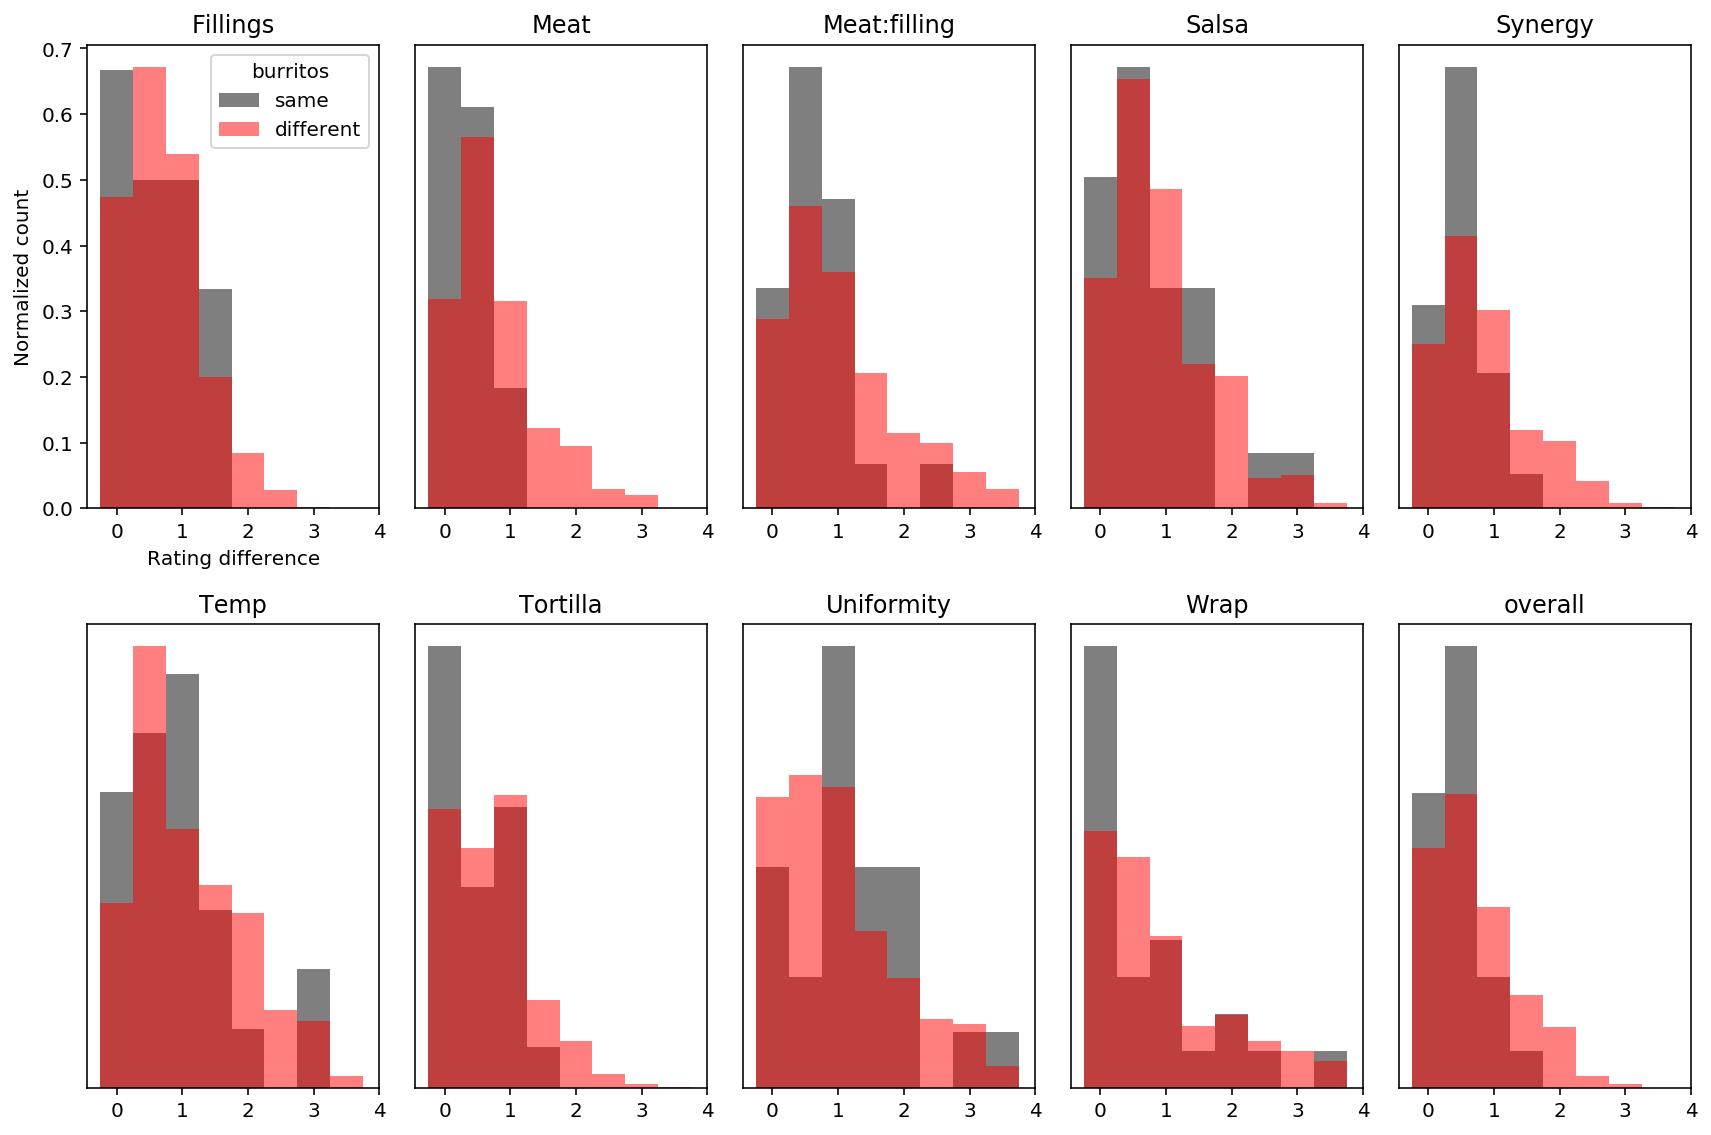

In [10]:
print('Feature     p-value\n-------     -------')
    
plt.figure(figsize=(12,8))
for i, k in enumerate(df_feat_diffs.keys()):
    plt.subplot(2,5,i+1)
    plt.hist(df_feat_diffs[k].values,np.arange(-.25,4,.5), color='k', normed=True, alpha=.5, label='same')
    plt.hist(feat_diffs_null[k],np.arange(-.25,4,.5), color='r', normed=True, alpha=.5, label='different')
    plt.title(k)
    plt.xticks(np.arange(0,5,1))
    if i == 0:
        plt.xlabel('Rating difference')
        plt.ylabel('Normalized count')
        plt.legend(loc='best', title='burritos')
    else:
        plt.yticks([])
    plt.tight_layout()
    
# Print stats
diff_sort_idx = np.argsort(meandiff_by_feat.values)
for k in df_feat_diffs.keys():
    t, p = sp.stats.mannwhitneyu(df_feat_diffs[k].values,feat_diffs_null[k])
    print('{: <14}{:.3f}  '.format(k, p))

# 3. Inter-reviewer reliability
### 3a. Determine inter-reviewer pairs

In [11]:
# Determine which burritos have been eaten at least twice
cols_keep = np.append(foi, ['Location', 'Burrito', 'Reviewer', 'Date'])
df2 = df[cols_keep].dropna(axis=0).reset_index(drop=True)
burrito_groups = df2.groupby(['Location', 'Burrito']).groups

# For each burrito group, make pairs of ratings
burrito_pairs_idxs = []
for k, idxs in burrito_groups.items():

    # Only consider burrito groups with more than 1 rating
    if len(idxs) >= 2:
        
        # Only consider burrito groups with more than 1 distinct reviewer and date
        reviewer_array = df2.loc[idxs]['Reviewer'].values
        date_array = df2.loc[idxs]['Date'].values
        if len(np.unique(reviewer_array)) > 1 and len(np.unique(date_array)) > 1:
            
            # Make new pairs as long as possible
            pairing_reviewers = np.copy(reviewer_array)
            pairing_dates = np.copy(date_array)
            pairing_idxs = np.copy(idxs)
            can_make_pair = True
            while can_make_pair:
                
                # Cannot make pair if less than 2 unique dates, 
                if len(np.unique(pairing_reviewers)) < 2 and len(np.unique(pairing_dates)) < 2:
                    can_make_pair = False

                else:
                    # Choose 1 random rating
                    rating1_i = pairing_idxs[0]
                    rating1_rev = pairing_reviewers[0]
                    rating1_date = pairing_dates[0]
                    
                    # Choose a rating that can go with this one
                    for i in range(1,len(pairing_idxs)):
                        rating2_i = pairing_idxs[i]
                        rating2_rev = pairing_reviewers[i]
                        rating2_date = pairing_dates[i]
                        if (rating1_rev != rating2_rev) and (rating1_date != rating2_date):
                            burrito_pairs_idxs.append([rating1_i, rating2_i])
                            
                            # remove those indices
                            pairing_reviewers = np.delete(pairing_reviewers, [0, i])
                            pairing_dates = np.delete(pairing_dates, [0, i])
                            pairing_idxs = np.delete(pairing_idxs, [0, i])
                            break

                        # Delete the first index if no pairings worked
                        if i == len(pairing_idxs)-1:
                            pairing_reviewers = np.delete(pairing_reviewers, 0)
                            pairing_dates = np.delete(pairing_dates, 0)
                            pairing_idxs = np.delete(pairing_idxs, 0)
                            

### 3b. Compute the difference in feature values for review pairs

In [14]:
N_pairs = len(burrito_pairs_idxs)

df_feat_diffs = pd.DataFrame()
for i in range(N_pairs):
    feature_diffs = np.abs(df_feat.loc[burrito_pairs_idxs[i][0]] - df_feat.loc[burrito_pairs_idxs[i][1]])
    df_feat_diffs = df_feat_diffs.append(feature_diffs, ignore_index=True)
    
# Compute average difference in each category
meandiff_by_feat = df_feat_diffs.mean()

# Print average difference in order
diff_sort_idx = np.argsort(meandiff_by_feat.values)
print('Diff   Feature\n----   -------')
for feat in meandiff_by_feat.keys()[diff_sort_idx]:
    print('{:.2f}  '.format(meandiff_by_feat[feat]), feat)

Diff   Feature
----   -------
0.47   overall
0.56   Meat
0.58   Fillings
0.64   Synergy
0.66   Tortilla
0.81   Meat:filling
0.85   Salsa
0.86   Wrap
0.98   Temp
1.23   Uniformity


### 3c. Compute null distribution of differences between burritos

In [17]:
np.random.seed(0)
N_sim = 1000 # Number of simulated burrito pairings

# Choose a random reviewer for each simulation
sim_rating1_options = np.hstack(burrito_pairs_idxs)
sim_rating1 = np.random.choice(sim_rating1_options, N_sim)
    
# Compute feature differences for random burritos
feat_diffs_null = defaultdict(list)
for i in range(N_sim):
    # Determine reviewer
    idx_rating1 = sim_rating1[i]
    rev1 = df2.loc[idx_rating1]['Reviewer']
    rest1 = df2.loc[idx_rating1]['Location']
    feats1 = df2.loc[idx_rating1].drop(['Location','Burrito','Reviewer','Date'])
    
    # Choose 2 valid random burritos from that reviewer
    got_2 = False
    while not got_2:
        # Choose another random burritos
        idx_rating2 = np.random.randint(len(df2))
        
        # Check if burritos are not from same restaurant
        rest2 = df2.loc[idx_rating2].Location
        rev2 = df2.loc[idx_rating2].Reviewer
        if (rest1 != rest2) and (rev1 != rev2):
            got_2 = True
            feats2 = df2.loc[idx_rating2].drop(['Location','Burrito','Reviewer','Date'])
            
    # Compute differences for each feature
    for k in feats1.keys():
        feat_diffs_null[k].append(np.abs(feats1[k] - feats2[k]))

### 3d. Distribution of feature differences: True and null

Feature     p-value
-------     -------
Fillings      0.057  
Meat          0.004  
Meat:filling  0.034  
Salsa         0.143  
Synergy       0.038  
Temp          0.370  
Tortilla      0.268  
Uniformity    0.457  
Wrap          0.204  
overall       0.010  


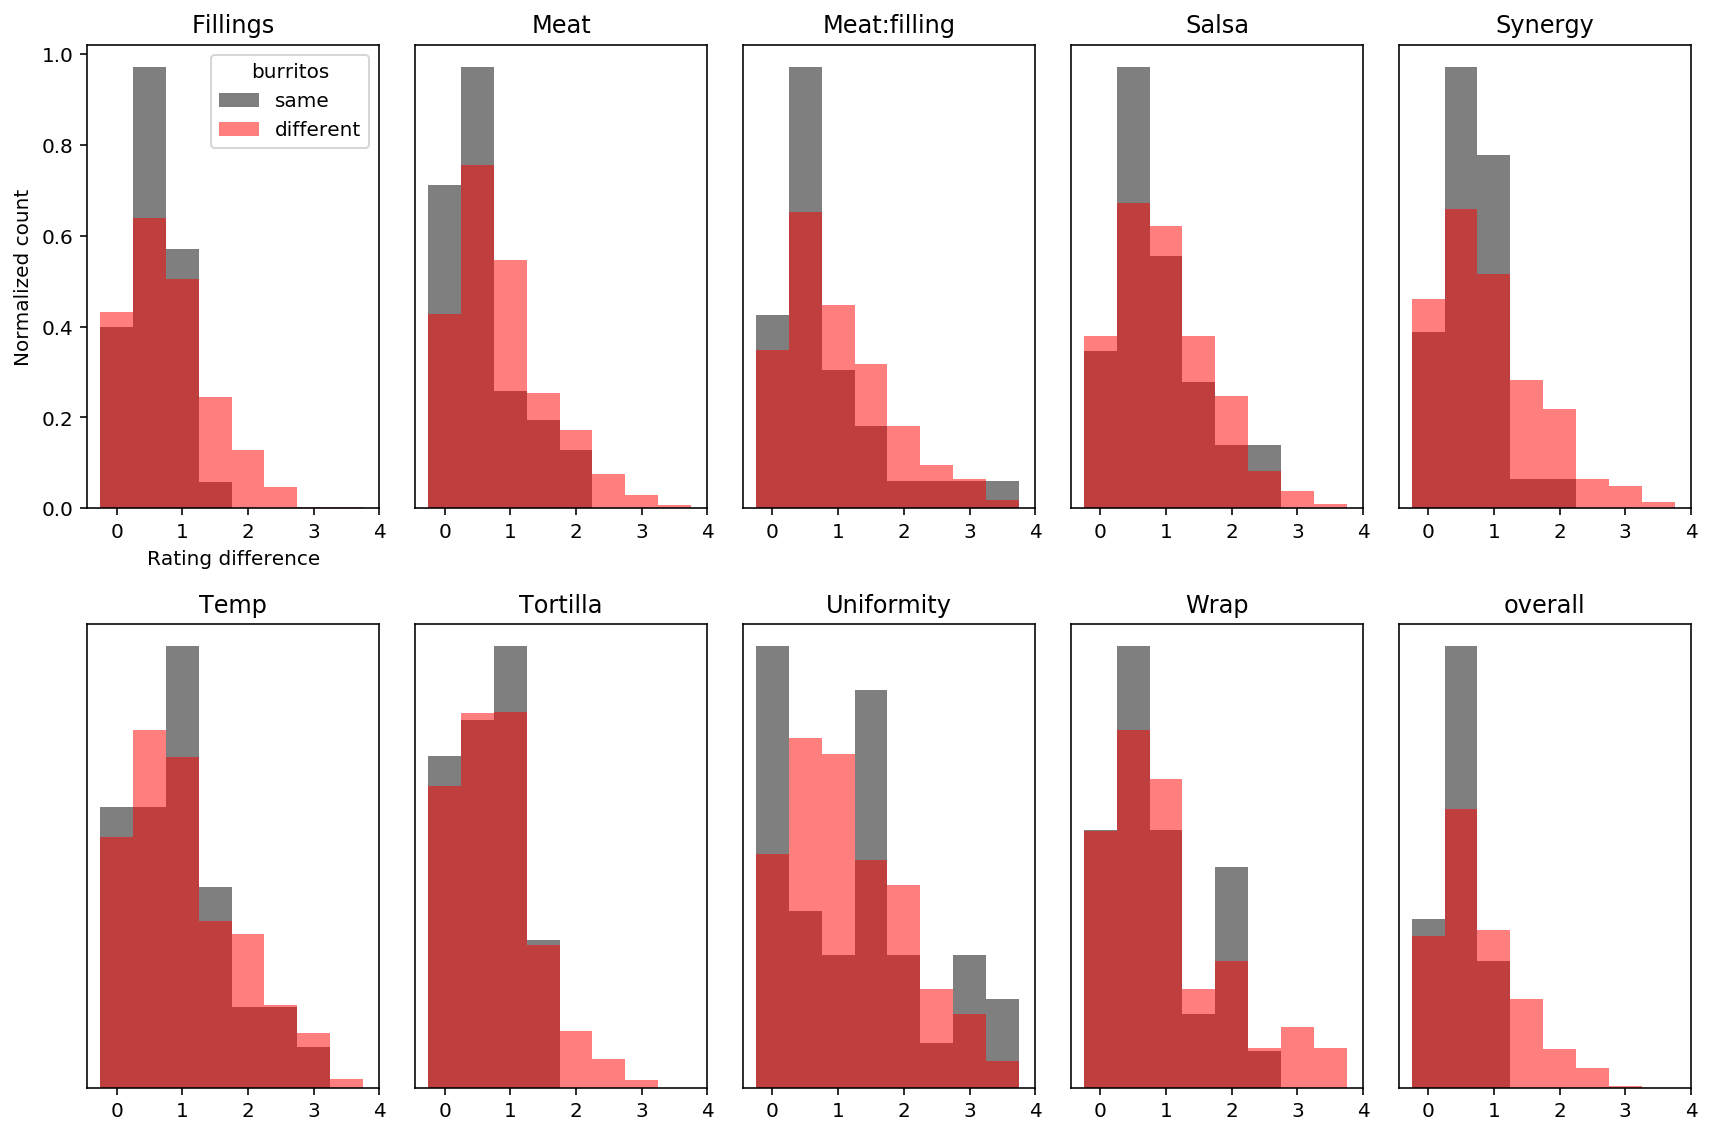

In [18]:
print('Feature     p-value\n-------     -------')
    
plt.figure(figsize=(12,8))
for i, k in enumerate(df_feat_diffs.keys()):
    plt.subplot(2,5,i+1)
    plt.hist(df_feat_diffs[k].values,np.arange(-.25,4,.5), color='k', normed=True, alpha=.5, label='same')
    plt.hist(feat_diffs_null[k],np.arange(-.25,4,.5), color='r', normed=True, alpha=.5, label='different')
    plt.title(k)
    plt.xticks(np.arange(0,5,1))
    if i == 0:
        plt.xlabel('Rating difference')
        plt.ylabel('Normalized count')
        plt.legend(loc='best', title='burritos')
    else:
        plt.yticks([])
    plt.tight_layout()
    
# Print stats
diff_sort_idx = np.argsort(meandiff_by_feat.values)
for k in df_feat_diffs.keys():
    t, p = sp.stats.mannwhitneyu(df_feat_diffs[k].values,feat_diffs_null[k])
    print('{: <14}{:.3f}  '.format(k, p))